<a href="https://colab.research.google.com/github/shivammehta007/NLPResearch/blob/master/Tutorials/PyTorch_Tutorial/Text4Thesis/KaggleCompetitionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trying NLP with a Beginner Dummy Competition**
https://www.kaggle.com/c/nlp-getting-started/overview

# Mounting Storage
Getting Data From Kaggle Server to Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install kaggle
import json
import os

with open('/content/drive/My Drive/kaggle.json') as kc:
    kaggle_config = json.load(kc)

os.environ['KAGGLE_USERNAME'] = kaggle_config['username'] 
os.environ['KAGGLE_KEY'] = kaggle_config['key'] 

!kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


# Imports

In [83]:
! pip install ekphrasis
! pip install -U tqdm
import random
import os
import re
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchtext import data


import matplotlib.pyplot as plt
import seaborn as sns

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

from string import punctuation
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')

nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.41.1)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Adding Custom Seed for reproducibility

In [0]:
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)

### Setting up pytorch's Device GPU/CPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

In [0]:
train_file = '/content/train.csv'
test_file = '/content/test.csv'

In [0]:
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [109]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## EDA

In [31]:
print(train_data.describe())
print('NaN values in Keyword: {}'.format(train_data['keyword'].isnull().sum()))
print('NaN values in location: {}'.format(train_data['location'].isnull().sum()))

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
NaN values in Keyword: 61
NaN values in location: 2533


### Drawing Missing Bar Plots and filling unknown information with UNK

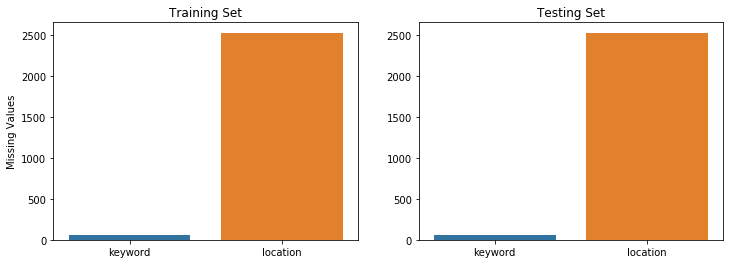

In [32]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(12,4))

sns.barplot(x=train_data[missing_cols].isnull().sum().index, y=train_data[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_data[missing_cols].isnull().sum().index, y=train_data[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Values')
axes[0].set_title('Training Set')
axes[1].set_title('Testing Set')

plt.show()

for dataset in [test_data, train_data]:
    for column in dataset[missing_cols]:
        dataset[column] = dataset[column].fillna('UNK')


### Make Distribution from Unique Words Present in Train and Test Set

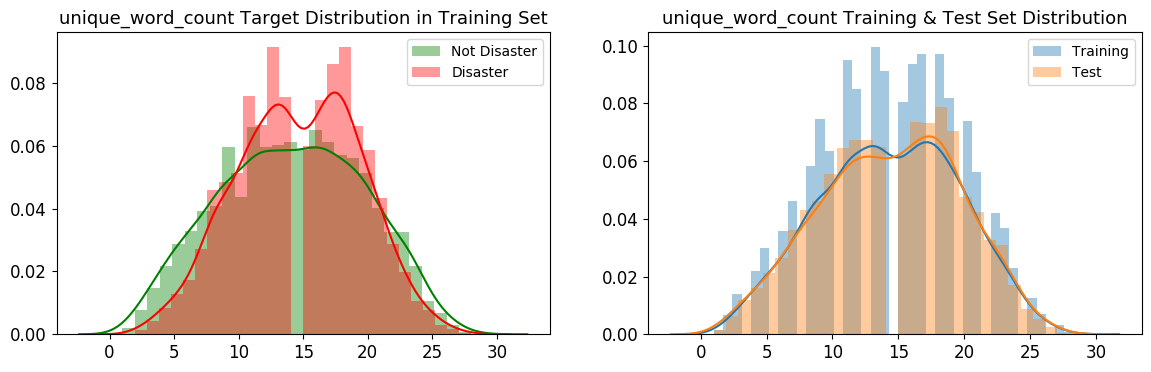

In [39]:
for dataset in [test_data, train_data]:
    dataset['unique_word_count'] = dataset['text'].apply(lambda x: len(set(str(x).split())))

DISASTER_TWEETS = train_data['target'] == 1


fig, axes = plt.subplots(ncols=2, figsize=(14, 4), dpi=100)
sns.distplot(train_data.loc[~DISASTER_TWEETS]['unique_word_count'], label='Not Disaster', ax=axes[0], color='green')
sns.distplot(train_data.loc[DISASTER_TWEETS]['unique_word_count'], label='Disaster', ax=axes[0], color='red')

sns.distplot(train_data['unique_word_count'], label='Training', ax=axes[1])
sns.distplot(test_data['unique_word_count'], label='Test', ax=axes[1])

for i in range(2):
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()

axes[0].set_title(f'unique_word_count Target Distribution in Training Set', fontsize=13)
axes[1].set_title(f'unique_word_count Training & Test Set Distribution', fontsize=13)

plt.show()

In [43]:
train_data.head()

,id,keyword,location,text,target,unique_word_count
0,1,UNK,UNK,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,UNK,UNK,Forest fire near La Ronge Sask. Canada,1,7
2,5,UNK,UNK,All residents asked to 'shelter in place' are ...,1,20
3,6,UNK,UNK,"13,000 people receive #wildfires evacuation or...",1,8
4,7,UNK,UNK,Just got sent this photo from Ruby #Alaska as ...,1,15


## We will be using only text information

### Preprocessing Data with Ekphrasis Since its Tweet Data

In [112]:

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # the tokenizer takes an input of a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def preprocess(text):
    text = text_processor.pre_process_doc(text)
    custom_stopwords = set(stopwords.words('english')) | set([i for i in punctuation])
    return ' '.join([word for word in text if word not in custom_stopwords])

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [0]:
train_data['text'] = train_data['text'].apply(preprocess)
test_data['text'] = test_data['text'].apply(preprocess)

In [114]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason <hashtag> earthquake </hashtag> m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,<number> people receive <hashtag> wildfires </...,1
4,7,NaN,NaN,got sent photo ruby <hashtag> alaska </hashtag...,1


In [0]:
train_data, validation_data = train_test_split(train_data, test_size=0.15)

In [116]:
len(train_data), len(validation_data), len(test_data)

(6471, 1142, 3263)

### Converting DataFrames to TorchText

In [0]:
def custom_tokenizer(text):
    return text.split()

In [0]:
TEXT = data.Field(tokenize=custom_tokenizer,init_token='<START>', eos_token='<END>', include_lengths = True)
LABEL = data.LabelField(dtype=torch.long)

In [0]:
fields = [('text', TEXT), ('target', LABEL)]


class DataFrameDataset(data.Dataset):
    """
    Custom Class for building DataFrame as DataSource
    """
    def __init__(self, dataframe, fields, filter_pred=None):
        """
        The Constructor for this class which will take dataframe and field
        :param: dataframe -> pd.DataFrame: DataFrame of data
        :param: fields -> (str: torchtext.data.Field): The fields to use in the \
                            tuple, where string is the field name and field is \
                            the data.Field
        :param: filter_pred -> (callable or None): Filter dataframe for which \
                                this predicate will be true, Default is None
        """
        examples = []
        required_columns = [tup[0] for tup in fields]
        for index, row in dataframe.iterrows():
            examples.append(data.Example.fromlist(row[required_columns].tolist(), fields))


        super(DataFrameDataset, self).__init__(examples, fields)

In [120]:
train_ds = DataFrameDataset(train_data, fields)
valid_ds = DataFrameDataset(validation_data, fields)
test_ds = DataFrameDataset(test_data, fields)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1155: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [121]:
len(train_ds), len(valid_ds), len(test_ds)

(6471, 1142, 3263)

In [123]:
for i , ex in enumerate(train_ds):
    if i == 5:
        break
    print(ex.text)

['<user>', '<user>', 'hampered', 'liking', 'cross', 'body', 'bags', 'really', 'like', 'ella', 'vickers', 'bags', 'machine', 'washable', '<url>']
['ca', 'cops', 'illegal', 'immigrant', '<number>', 'prior', 'arrests', 'charged', 'fatal', 'sex', 'attack', '<url>']
['get', 'smoke', 'shit', 'peace']
['eric', 'clapton', 'shot', 'sheriff', '<number>', 'guess', 'many', 'people', 'rioting', 'right', 'none']
['newberg', 'upheaval', 'jacque', 'betz', 'responds', 'looking', 'forward', 'day', 'answer', 'questions', '<hashtag>', 'cot', '</hashtag>', '<hashtag>', 'pol', '</hashtag>', '<url>']


In [124]:
# MAX_VOCAB_SIZE = 25000
# TEXT.build_vocab(sa_train_data.TweetText, max_size=MAX_VOCAB_SIZE) 
# LABEL.build_vocab(sa_train_data.Sentiment)

NameError: ignored